# Classification of HiTS

In [15]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from astropy.table import Table
from metric_tools import *
from sklearn.externals import joblib

%matplotlib inline
sns.set(style="white", color_codes=True, context="notebook", font_scale=1.4)

mainpath = '/Users/jorgetil/Astro/HITS'

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

## Labeled set

In [17]:
table_file = '%s/tables/HiTS_training_set_clean_DA.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('internalID')
print label_samp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11229 entries, Blind15A_27_N3_0379_3173 to 4998
Data columns (total 74 columns):
ID                                 5518 non-null object
raMedian                           5518 non-null float64
decMedian                          5518 non-null float64
X                                  5518 non-null float64
Y                                  5518 non-null float64
spCl                               483 non-null object
spSubCl                            421 non-null object
Var_Type                           11229 non-null object
Var_subType                        196 non-null object
Amplitude                          11229 non-null float64
AndersonDarling                    11229 non-null float64
Autocor_length                     11229 non-null float64
Beyond1Std                         11229 non-null float64
CAR_mean                           11229 non-null float64
CAR_sigma                          11229 non-null float64
CAR_tau             

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,6,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
label_samp.head()

,ID,raMedian,decMedian,X,Y,spCl,spSubCl,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_27_N3_0379_3173,HiTS095752+000705,149.469219,0.118146,379.931812,3173.503231,STAR,F9,EB,EW,0.136794,...,0.152811,0.248793,0.067351,-0.437266,0.079331,0.805753,0.763510,0.534005,0.550113,-0.016108
Blind15A_27_N17_1603_2975,HiTS095941-001804,149.920940,-0.301144,1603.779358,2975.716134,STAR,A0,EB,EW,0.154297,...,0.155952,0.445286,0.067351,-1.108135,0.103144,0.887858,0.865706,-0.123763,-0.072581,-0.051182
Blind15A_27_N31_0403_2678,HiTS100013-004221,150.054236,-0.705970,403.725510,2678.952948,STAR,K3,EB,EW,0.165890,...,0.144590,0.393764,0.067351,-0.828686,0.107814,0.814817,0.855628,-1.215272,-0.863064,-0.352209
Blind15A_35_N8_1315_3230,HiTS100646+014956,151.692915,1.832412,1315.940043,3230.151539,STAR,F9,EB,EW,0.110125,...,0.125448,0.026960,0.067353,-1.247660,0.074630,0.852220,0.772061,0.556697,0.459707,0.096990
Blind15A_35_S19_0741_3050,HiTS101256+023150,153.235085,2.530767,741.514514,3050.037263,STAR,A0,EB,EW,0.186335,...,0.222970,1.335263,0.067353,2.059167,0.101997,0.818950,0.759416,-0.212511,-0.193913,-0.018598


In [19]:
label_samp.Var_Type.value_counts()

NV        9999
EB         311
RRLYR      280
ROTVAR     190
QSO        177
DSCT       158
CV          94
SNe         12
MISC         7
LPV          1
Name: Var_Type, dtype: int64

In [20]:
print 'original shape:', label_samp.shape
cols = label_samp.columns.values
FATS_feats_all = cols[9:]
FATS_feats_gr = FATS_feats_all[(FATS_feats_all != 'g-i') & (FATS_feats_all != 'r-i')]
FATS_feats_non = cols[9:-3]
FATS_feats_non_mean = FATS_feats_non[(FATS_feats_non != 'Mean') & 
                                     (FATS_feats_non != 'CAR_mean') & 
                                     (FATS_feats_non != 'Meanvariance')]
print FATS_feats_non_mean

label_samp_all = label_samp.dropna(subset=FATS_feats_all)
label_samp_gr = label_samp.dropna(subset=FATS_feats_gr)
label_samp_non = label_samp.dropna(subset=FATS_feats_non)

print len(FATS_feats_all)

original shape: (11229, 74)
['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_sigma'
 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gske

In [25]:
cv_set, test_set = model_selection.train_test_split(label_samp_non, 
                                                    test_size=1/3.,
                                                    random_state=58)
print cv_set.shape
print cv_set.Var_Type.value_counts()
print test_set.shape
print test_set.Var_Type.value_counts()

(7486, 74)
NV        6647
EB         208
RRLYR      193
ROTVAR     132
QSO        125
DSCT       108
CV          61
SNe          8
MISC         4
Name: Var_Type, dtype: int64
(3743, 74)
NV        3352
EB         103
RRLYR       87
ROTVAR      58
QSO         52
DSCT        50
CV          33
SNe          4
MISC         3
LPV          1
Name: Var_Type, dtype: int64


In [30]:
y_var = conv_into_binary_class(syn_sample_noqso['Var_Type'].values,
                             neg_bool=True, neg_label='NV')
print'Var/nonVar:',
print '%i/%i' % (y_var[y_var==1].shape[0],
                 y_var[y_var==0].shape[0])

Var/nonVar: 943/6000


In [14]:
RFC = RandomForestClassifier(n_estimators=30, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)

scores = model_selection.cross_val_score(RFC, syn_sample_noqso[FATS_feats_non],
                                         y_var, scoring='f1', cv=ss, n_jobs=2, verbose=1)
predict_class_v = model_selection.cross_val_predict(RFC, syn_sample_noqso[FATS_feats_non],
                                   y_var, cv=10, n_jobs=2, verbose=1, method='predict')
predict_proba_v = model_selection.cross_val_predict(RFC, syn_sample_noqso[FATS_feats_non],
                                   y_var, cv=10, n_jobs=2, verbose=1, method='predict_proba')

NameError: name 'syn_sample_noqso' is not defined

In [13]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(y_var, predict_class_v)
save_path = '%s/figures/conf_matrix_var_nonvar_RFC_orgTS.pdf' % (mainpath)
conf_matrix(true=y_var, predict=predict_class_v, classes=[0,1], save=save_path, normalized=True,
           class_names=['NonVariable', 'Variable'])

ROC_F1_thresh_curves_binary(y_var.ravel(), predict_proba_v[:, 1])

Accuracy = 

NameError: name 'scores' is not defined

### Periodic vs NonPeriodic

In [46]:
label_samp_varonly = syn_sample.query('~(Var_Type == "QSO" or Var_Type == "NV")')
label_samp_varonly = pd.concat([label_samp_varonly, var_qso], axis=0)
print label_samp_varonly.shape

y_periodic = conv_into_binary_class(label_samp_varonly_goodPF['Var_Type'].values,
                             pos_label=['RRLYR','EB','ROTVAR','DSCT','ZZ','LPV'])

(1118, 75)


In [59]:
print'Periodic/nonPeriodic:',
print '%i/%i' % (y_periodic[y_periodic==1].shape[0],
                 y_periodic[y_periodic==0].shape[0])

RFC = RandomForestClassifier(n_estimators=50, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced')

scores = model_selection.cross_val_score(RFC, label_samp_varonly_goodPF[FATS_feats_non],
                                         y_periodic, scoring='f1', cv=ss, n_jobs=2, verbose=1)
predict_prob = model_selection.cross_val_predict(RFC, label_samp_varonly_goodPF[FATS_feats_non],
                                               y_periodic, cv=10, n_jobs=2, verbose=1, method='predict_proba')
predict_lab = [np.argmax(x) for x in predict_prob]

Periodic/nonPeriodic: 948/170


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.6s finished


Accuracy =  0.99421861901 +- 0.00497240952414
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       170
          1       0.99      0.99      0.99       948

avg / total       0.98      0.98      0.98      1118



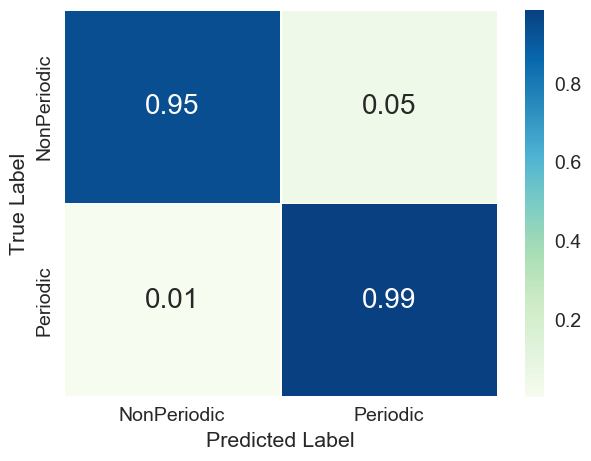

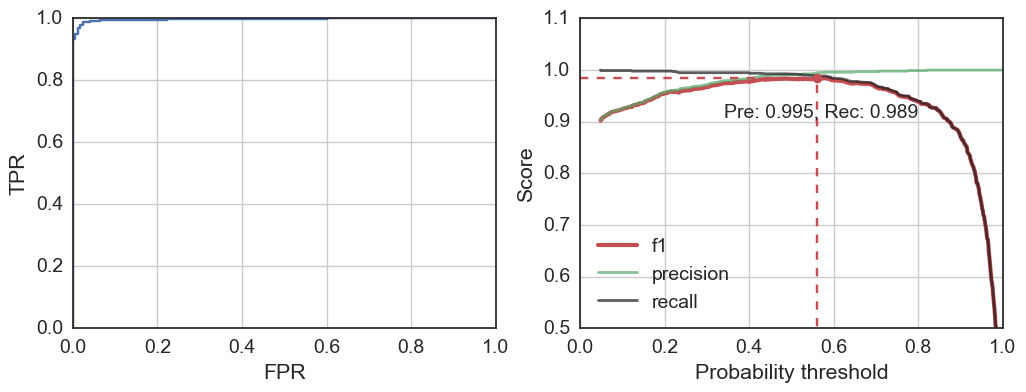

In [60]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(y_periodic, predict_lab)
save_path = '%s/figures/conf_matrix_per_nonper_RFC.pdf' % (mainpath)
conf_matrix(true=y_periodic, predict=predict_lab, classes=[0,1], save=save_path, normalized=True,
           class_names=['NonPeriodic', 'Periodic'])
ROC_F1_thresh_curves_binary(y_periodic.ravel(), predict_prob[:, 1])

## Only periodic 

In [56]:
sub_periodic = label_samp_varonly_goodPF.query('Var_Type == "RRLYR" or Var_Type == "EB" or \
                                                Var_Type == "DSCT" or Var_Type == "ROTVAR"')

In [134]:
RFC = RandomForestClassifier(n_estimators=40, criterion='entropy',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=False,
                            class_weight='balanced')


ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)

scores = model_selection.cross_val_score(RFC, sub_periodic[FATS_feats_non], sub_periodic['Var_Type'], 
                                         scoring='f1_macro', cv=ss, n_jobs=2, verbose=1)
clases = list(set(sub_periodic['Var_Type']))

pred_y = model_selection.cross_val_predict(RFC, sub_periodic[FATS_feats_non],
                                               sub_periodic['Var_Type'], cv=10, n_jobs=2, verbose=1)
pred_prob = model_selection.cross_val_predict(RFC, sub_periodic[FATS_feats_non],
                                               sub_periodic['Var_Type'], method='predict_proba',
                                              cv=10, n_jobs=2,verbose=1)

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.0s finished


Accuracy =  0.925191433319 +- 0.0321364000518
             precision    recall  f1-score   support

       DSCT       0.96      0.96      0.96       166
         EB       0.84      0.89      0.86        87
     ROTVAR       0.93      0.93      0.93       174
      RRLYR       0.97      0.93      0.95       134

avg / total       0.93      0.93      0.93       561



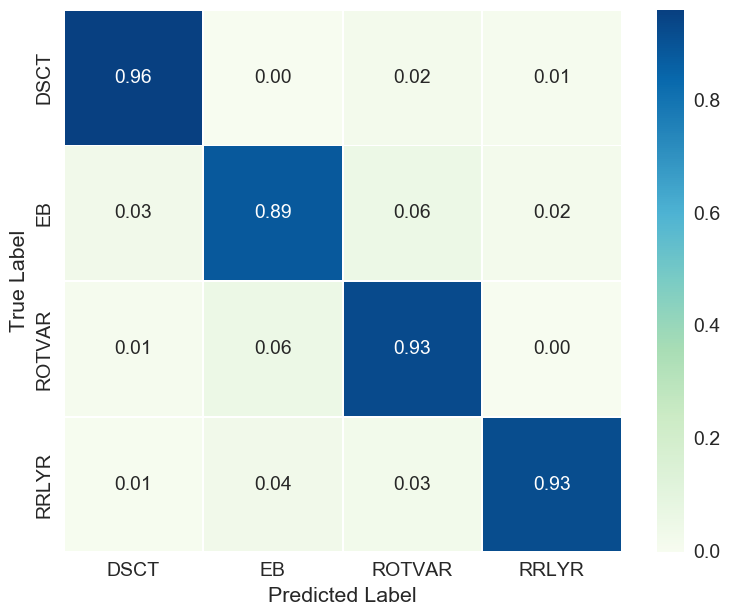

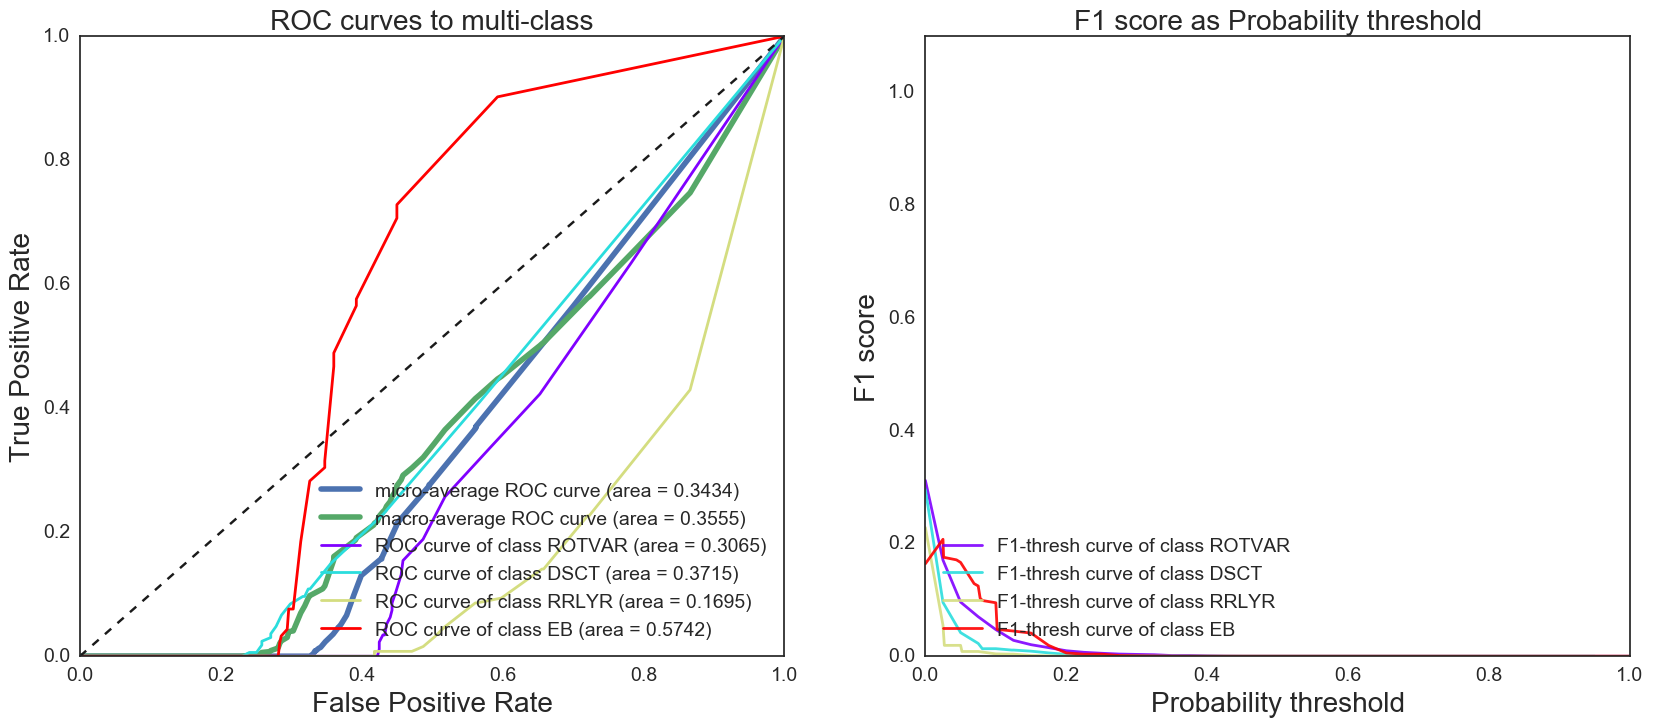

In [135]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(sub_periodic['Var_Type'], pred_y)

save_path = '%s/figures/conf_matrix_per_subcls_RFC.pdf' % (mainpath)
conf_matrix(true=sub_periodic['Var_Type'], predict=pred_y, 
            classes=clases, save=save_path, normalized=True)
ROC_F1_thresh_curves_multiclass(pred_y, y_score=pred_prob, classes=clases)

### NonPeriodic subclasses

In [63]:
label_samp_varonly_nonP = label_samp_varonly.query('Var_Type == "QSO" or \
                                                    Var_Type == "CV" or \
                                                    Var_Type == "SNe"')
print label_samp_varonly_nonP.Var_Type.value_counts()
label_samp_varonly_nonP.dropna(subset=FATS_feats_all).Var_Type.value_counts()

CV     94
QSO    57
SNe    12
Name: Var_Type, dtype: int64


In [69]:
RFC = RandomForestClassifier(n_estimators=20, criterion='entropy',
                           max_features='sqrt', max_depth=8, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

ss = model_selection.StratifiedKFold(n_splits=6, random_state=10)

scores = model_selection.cross_val_score(RFC, label_samp_varonly_nonP[FATS_feats_non],
                                         label_samp_varonly_nonP['Var_Type'], 
                                         scoring='accuracy', cv=ss, n_jobs=2, verbose=1)
clases = list(set(label_samp_varonly_nonP['Var_Type']))
prediction = model_selection.cross_val_predict(RFC, label_samp_varonly_nonP[FATS_feats_non],
                                   label_samp_varonly_nonP['Var_Type'], cv=10, n_jobs=2,
                                                 verbose=1, method='predict')

[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.7s finished


Accuracy =  0.913715913716 +- 0.0281777980716
             precision    recall  f1-score   support

         CV       0.91      0.97      0.94        94
        QSO       0.92      0.86      0.89        57
        SNe       0.80      0.67      0.73        12

avg / total       0.91      0.91      0.91       163



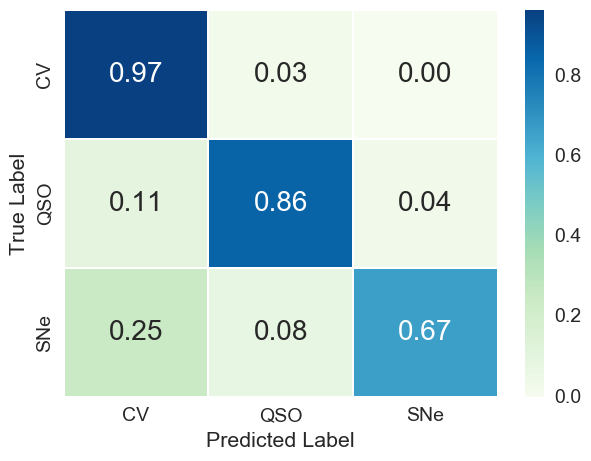

In [71]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(label_samp_varonly_nonP['Var_Type'], prediction)
save_path = '%s/figures/conf_matrix_nonper_subclasses.pdf' % (mainpath)
conf_matrix(true=label_samp_varonly_nonP['Var_Type'], predict=prediction, 
            classes=clases, save=save_path, normalized=True)